In [10]:
import os
import sys

print("Current working directory:", os.getcwd())
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    print(f"Added {parent_dir} to Python path")
else:
    print(f"{parent_dir} already in Python path")

Current working directory: /Users/jinceyang/Desktop/codebase/ml/learn_d2l/chap8
/Users/jinceyang/Desktop/codebase/ml/learn_d2l already in Python path


In [ ]:
import importlib
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import numpy as np

import importlib
from d2l.classification.model import LeNetBNClassifier, LeNetBNClassifierTorch, LeNetClassifierTorch
from d2l.classification.dataset import FashionMNISTDataset
from d2l.base.trainer import Trainer
from d2l.base.evaluator import ClassificationEvaluator
from d2l.base.optimizer import SGDOptimizer
from d2l.base.plot import plot_loss, show_images, plot_losses
from d2l.base.utils import mps
from typing import List
from matplotlib import pyplot as plt
import torch
import numpy as np

from d2l.base.function import corr2d, corr2d_multi_in, corr2d_multi_in_out, corr2d_multi_in_out_1x1, comp_conv2d, max_pool2d, avg_pool2d

In [12]:
rng = torch.Generator().manual_seed(42)

In [13]:
data = FashionMNISTDataset()
train_data_loader = data.get_train_dataloader(batch_size=10)
train_iter = iter(train_data_loader)
X, y = next(train_iter)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: torch.Size([10, 1, 28, 28])
y shape: torch.Size([10])


In [14]:
from d2l import LeNetClassifierTorch

lenet = LeNetClassifierTorch(
    num_outputs=10,
    rng=rng
)

lenet.init((10, 1, 28, 28))
lenet.layer_summary((10, 1, 28, 28))

              Conv2d  input shape: torch.Size([10, 1, 28, 28])
              Conv2d  output shape: torch.Size([10, 6, 28, 28])
             Sigmoid  input shape: torch.Size([10, 6, 28, 28])
             Sigmoid  output shape: torch.Size([10, 6, 28, 28])
           AvgPool2d  input shape: torch.Size([10, 6, 28, 28])
           AvgPool2d  output shape: torch.Size([10, 6, 14, 14])
              Conv2d  input shape: torch.Size([10, 6, 14, 14])
              Conv2d  output shape: torch.Size([10, 16, 10, 10])
             Sigmoid  input shape: torch.Size([10, 16, 10, 10])
             Sigmoid  output shape: torch.Size([10, 16, 10, 10])
           AvgPool2d  input shape: torch.Size([10, 16, 10, 10])
           AvgPool2d  output shape: torch.Size([10, 16, 5, 5])
             Flatten  input shape: torch.Size([10, 16, 5, 5])
             Flatten  output shape: torch.Size([10, 400])
              Linear  input shape: torch.Size([10, 400])
              Linear  output shape: torch.Size([10, 120])


In [ ]:
lenet_bn = LeNetBNClassifierTorch(
    num_outputs=10,
    rng=rng
)
lenet_bn.init((10, 1, 28, 28))
lenet_bn.layer_summary((10, 1, 28, 28))

              Conv2d  input shape: torch.Size([10, 1, 28, 28])
              Conv2d  output shape: torch.Size([10, 6, 28, 28])
         BatchNorm2d  input shape: torch.Size([10, 6, 28, 28])
         BatchNorm2d  output shape: torch.Size([10, 6, 28, 28])
             Sigmoid  input shape: torch.Size([10, 6, 28, 28])
             Sigmoid  output shape: torch.Size([10, 6, 28, 28])
           AvgPool2d  input shape: torch.Size([10, 6, 28, 28])
           AvgPool2d  output shape: torch.Size([10, 6, 14, 14])
              Conv2d  input shape: torch.Size([10, 6, 14, 14])
              Conv2d  output shape: torch.Size([10, 16, 10, 10])
         BatchNorm2d  input shape: torch.Size([10, 16, 10, 10])
         BatchNorm2d  output shape: torch.Size([10, 16, 10, 10])
             Sigmoid  input shape: torch.Size([10, 16, 10, 10])
             Sigmoid  output shape: torch.Size([10, 16, 10, 10])
           AvgPool2d  input shape: torch.Size([10, 16, 10, 10])
           AvgPool2d  output shape: torch.

In [ ]:
lenet_bn_s = LeNetBNClassifier(
    num_outputs=10,
    rng=rng
)
lenet_bn_s.init((10, 1, 28, 28))
lenet_bn_s.layer_summary((10, 1, 28, 28))

              Conv2d  input shape: torch.Size([10, 1, 28, 28])
              Conv2d  output shape: torch.Size([10, 6, 28, 28])
         BatchNorm2d  input shape: torch.Size([10, 6, 28, 28])
         BatchNorm2d  output shape: torch.Size([10, 6, 28, 28])
             Sigmoid  input shape: torch.Size([10, 6, 28, 28])
             Sigmoid  output shape: torch.Size([10, 6, 28, 28])
           AvgPool2d  input shape: torch.Size([10, 6, 28, 28])
           AvgPool2d  output shape: torch.Size([10, 6, 14, 14])
              Conv2d  input shape: torch.Size([10, 6, 14, 14])
              Conv2d  output shape: torch.Size([10, 16, 10, 10])
         BatchNorm2d  input shape: torch.Size([10, 16, 10, 10])
         BatchNorm2d  output shape: torch.Size([10, 16, 10, 10])
             Sigmoid  input shape: torch.Size([10, 16, 10, 10])
             Sigmoid  output shape: torch.Size([10, 16, 10, 10])
           AvgPool2d  input shape: torch.Size([10, 16, 10, 10])
           AvgPool2d  output shape: torch.

In [17]:
def eval_on_epoch(model, epoch_id, batch_losses):
    evaluator = ClassificationEvaluator(model)
    loss = evaluator.loss(data.get_test_dataloader(batch_size=data.test_size))
    print(f'Epoch {epoch_id}, validation loss {loss:.4f}')
    accuracy = evaluator.accuracy(data.get_test_dataloader(batch_size=data.test_size))
    print(f'Epoch {epoch_id}, validation accuracy {accuracy:.4f}')

In [18]:
trainer = Trainer(
    model=lenet, 
    optimizer=torch.optim.Adam(lenet.net.parameters(), lr=0.005),
    on_train_epoch_end=eval_on_epoch
)
trainer_bn = Trainer(
    model=lenet_bn, 
    optimizer=torch.optim.Adam(lenet_bn.net.parameters(), lr=0.005),
    on_train_epoch_end=eval_on_epoch
)
trainer_bn_s = Trainer(
    model=lenet_bn_s, 
    optimizer=torch.optim.Adam(lenet_bn_s.net.parameters(), lr=0.005),
    on_train_epoch_end=eval_on_epoch
)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0, validation loss 0.6744
Epoch 0, validation accuracy 0.7456


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1, validation loss 0.5273
Epoch 1, validation accuracy 0.7936


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2, validation loss 0.4536
Epoch 2, validation accuracy 0.8329


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3, validation loss 0.4542
Epoch 3, validation accuracy 0.8264


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4, validation loss 0.4177
Epoch 4, validation accuracy 0.8468


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5, validation loss 0.4069
Epoch 5, validation accuracy 0.8468


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6, validation loss 0.3909
Epoch 6, validation accuracy 0.8557


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7, validation loss 0.3643
Epoch 7, validation accuracy 0.8626


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8, validation loss 0.3600
Epoch 8, validation accuracy 0.8657


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9, validation loss 0.3503
Epoch 9, validation accuracy 0.8662


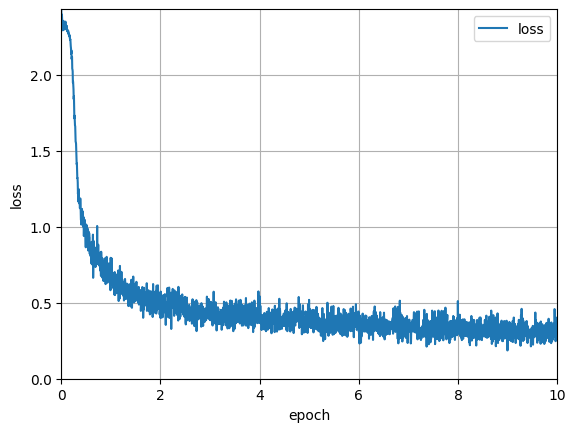

In [19]:
epoch_losses = trainer.train(
    data.get_train_dataloader_epochs(batch_size=256, num_epochs=10)
)
fig, ax = plt.subplots()
plot_loss(ax, epoch_losses)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0, validation loss 0.5093
Epoch 0, validation accuracy 0.8106


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1, validation loss 0.4300
Epoch 1, validation accuracy 0.8407


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2, validation loss 0.3594
Epoch 2, validation accuracy 0.8716


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3, validation loss 0.3599
Epoch 3, validation accuracy 0.8722


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4, validation loss 0.3491
Epoch 4, validation accuracy 0.8766


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5, validation loss 0.3131
Epoch 5, validation accuracy 0.8858


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6, validation loss 0.4520
Epoch 6, validation accuracy 0.8256


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7, validation loss 0.3087
Epoch 7, validation accuracy 0.8838


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8, validation loss 0.3015
Epoch 8, validation accuracy 0.8908


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9, validation loss 0.2985
Epoch 9, validation accuracy 0.8913


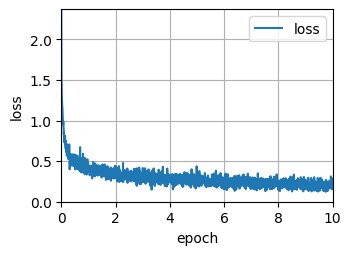

In [20]:
epoch_losses = trainer_bn.train(
    data.get_train_dataloader_epochs(batch_size=256, num_epochs=10)
)
fig, ax = plt.subplots()
plot_loss(ax, epoch_losses)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 0, validation loss 0.7959
Epoch 0, validation accuracy 0.6971


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1, validation loss 0.4263
Epoch 1, validation accuracy 0.8424


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2, validation loss 0.3800
Epoch 2, validation accuracy 0.8584


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3, validation loss 0.3497
Epoch 3, validation accuracy 0.8710


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4, validation loss 0.3250
Epoch 4, validation accuracy 0.8807


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5, validation loss 0.3736
Epoch 5, validation accuracy 0.8550


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6, validation loss 0.2903
Epoch 6, validation accuracy 0.8929


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7, validation loss 0.2911
Epoch 7, validation accuracy 0.8945


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8, validation loss 0.3138
Epoch 8, validation accuracy 0.8854


Batch:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9, validation loss 0.2638
Epoch 9, validation accuracy 0.9023


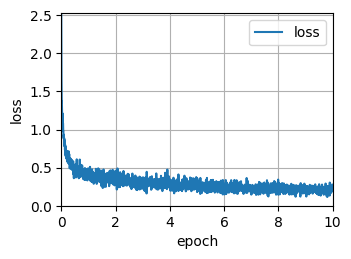

In [21]:
epoch_losses = trainer_bn_s.train(
    data.get_train_dataloader_epochs(batch_size=256, num_epochs=10)
)
fig, ax = plt.subplots()
plot_loss(ax, epoch_losses)

In [22]:
evaluator = ClassificationEvaluator(lenet)
test_loss = evaluator.loss(data.get_test_dataloader(data.test_size))
print(f'Test loss: {test_loss:.4f}')
accuracy = evaluator.accuracy(data.get_test_dataloader(data.test_size))
print(f'Test accuracy: {accuracy:.2%}')

Test loss: 0.3503
Test accuracy: 86.62%


In [23]:
evaluator = ClassificationEvaluator(lenet_bn)
test_loss = evaluator.loss(data.get_test_dataloader(data.test_size))
print(f'Test loss (bn) : {test_loss:.4f}')
accuracy = evaluator.accuracy(data.get_test_dataloader(data.test_size))
print(f'Test accuracy (bn): {accuracy:.2%}')

Test loss (bn) : 0.2985
Test accuracy (bn): 89.13%


In [24]:
evaluator = ClassificationEvaluator(lenet_bn_s)
test_loss = evaluator.loss(data.get_test_dataloader(data.test_size))
print(f'Test loss (bn_s): {test_loss:.4f}')
accuracy = evaluator.accuracy(data.get_test_dataloader(data.test_size))
print(f'Test accuracy (bn_s): {accuracy:.2%}')

Test loss (bn_s): 0.2638
Test accuracy (bn_s): 90.23%


In [25]:
# save the models   
lenet_bn_s.save('lenet_bn_s.pth')
lenet_bn.save('lenet_bn.pth')